## **Preparação do ambiente, importação dos dados e análise exploratória**


In [ ]:
#Bibliotecas utilizadas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, ElasticNet#, LinearRegression, BayesianRidge
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
import xgboost as xgb
import lightgbm as lgb
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

#Dados de coleta importados via csv de um repositório no github
#Link do repositório: https://github.com/eduardoscavalcanti/TCC_inteligencia_artificial_trocador_de_calor
raw_data =     'https://raw.githubusercontent.com/eduardoscavalcanti/TCC_inteligencia_artificial_trocador_de_calor/main/dados_treino_completo.csv'#16800


df = pd.read_csv(raw_data)
df

#'https://raw.githubusercontent.com/eduardoscavalcanti/TCC_inteligencia_artificial_trocador_de_calor/main/dados_treino.csv'#12600
#'https://raw.githubusercontent.com/eduardoscavalcanti/TCC_inteligencia_artificial_trocador_de_calor/main/dados_grupo_8.csv'#80
#'https://raw.githubusercontent.com/eduardoscavalcanti/TCC_inteligencia_artificial_trocador_de_calor/main/dados_treino%20kelvin.csv'#16800 kelvin

,Data,T1,T2,T3,T4,F1,F2,Amostra
0,26/10/2022 16:44:43321600,37.0636,28.2552,25.8884,25.0832,12.614795,0.0,acq500
1,26/10/2022 16:44:44335600,37.1368,28.2308,26.0348,25.0832,7.986195,0.0,acq500
2,26/10/2022 16:44:45334000,37.0880,28.0600,25.9616,25.1564,10.763355,0.0,acq500
3,26/10/2022 16:44:46394800,37.1124,27.9380,25.8396,25.1076,11.689075,0.0,acq500
4,26/10/2022 16:44:47330800,36.9660,27.9380,25.8884,25.1076,12.614795,0.0,acq500
...,...,...,...,...,...,...,...,...
16794,26/09/2022 21:16:20761000,39.5524,28.7188,30.1096,19.8860,241.267635,852.0,4200v0
16795,26/09/2022 21:16:21759400,39.5768,28.7920,30.1096,19.8616,241.267635,848.0,4200v0
16796,26/09/2022 21:16:22757800,39.5768,28.7188,30.1096,19.8616,242.193355,850.0,4200v0
16797,26/09/2022 21:16:23756200,39.5524,28.7432,30.1096,19.8860,241.267635,852.0,4200v0


In [ ]:
#Remoção de vazoes quente e fria menores que 50 L/h 
df.drop(df[df.F1 < 50].index, inplace=True)
df.drop(df[df.F2 < 50].index, inplace=True)

df.sort_values(by=['F1'],inplace = True)
#Reset index
df.reset_index(inplace = True)

In [ ]:


df_train = df[df.F1 <= 220]
df_test = df[df.F1 > 220]

#Colunas renomeadas para maior clareza
df_train.rename(columns={'T1': 'T1 - Entrada Quente', 
                   'T2': 'T2 - Saída Quente', 
                   'T3': 'T3 - Saída Fria',
                   'T4': 'T4 - Entrada Fria',
                   'F1': 'F1 - Vazão Quente',
                   'F2': 'F2 - Vazão Fria'
}, inplace=True)

#Colunas renomeadas para maior clareza
df_test.rename(columns={'T1': 'T1 - Entrada Quente', 
                   'T2': 'T2 - Saída Quente', 
                   'T3': 'T3 - Saída Fria',
                   'T4': 'T4 - Entrada Fria',
                   'F1': 'F1 - Vazão Quente',
                   'F2': 'F2 - Vazão Fria'
}, inplace=True)




/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


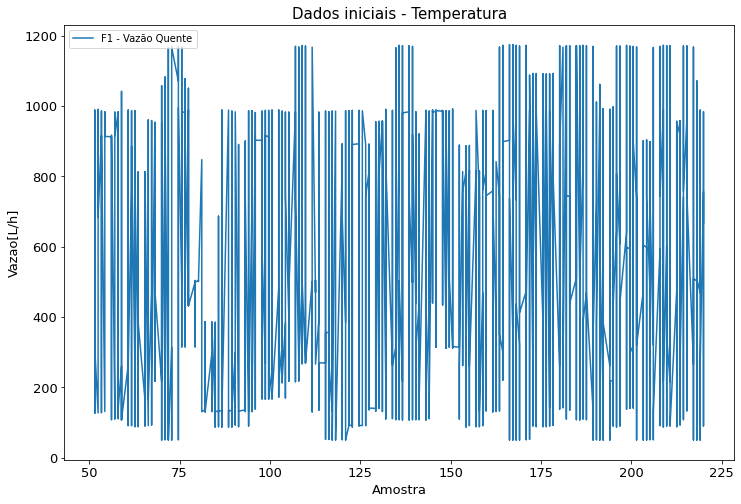

In [ ]:
#Plot das vazoes
plt.figure(figsize=(12,8))
plt.plot(df_train['F1 - Vazão Quente'], df_train['F2 - Vazão Fria'])
plt.title('Dados iniciais - Temperatura',fontsize=15)
plt.legend(['F1 - Vazão Quente', 'F2 - Vazão Fria'],loc=0)
plt.xlabel('Amostra',fontsize=13)
plt.ylabel('Vazao[L/h]',fontsize=13)
plt.tick_params(labelsize=13)
plt.show()

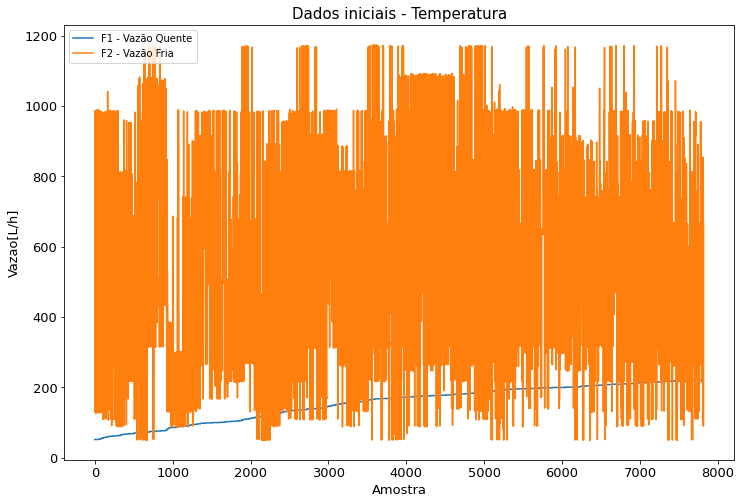

In [ ]:
#Plot das vazoes
plt.figure(figsize=(12,8))
plt.plot(df_train.index, df_train['F1 - Vazão Quente'])
plt.plot(df_train.index, df_train['F2 - Vazão Fria'])
plt.title('Dados iniciais - Temperatura',fontsize=15)
plt.legend(['F1 - Vazão Quente', 'F2 - Vazão Fria'],loc=0)
plt.xlabel('Amostra',fontsize=13)
plt.ylabel('Vazao[L/h]',fontsize=13)
plt.tick_params(labelsize=13)
plt.show()

## **Preparação dos dados**

In [ ]:
X_train = df_train[['T1 - Entrada Quente','T2 - Saída Quente','T3 - Saída Fria','T4 - Entrada Fria','F2 - Vazão Fria']]
X_test = df_test[['T1 - Entrada Quente','T2 - Saída Quente','T3 - Saída Fria','T4 - Entrada Fria','F2 - Vazão Fria']]
y_train = df_train['F1 - Vazão Quente']
y_test =df_test['F1 - Vazão Quente']

In [ ]:
#Seed
SEED = 7
np.random.seed(SEED)

#Dados normalizados de -1 a 1 pela biblioteca StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


In [ ]:
X_test

array([[-0.59604369,  0.37898454,  0.36661402,  0.60728828, -0.21627264],
       [-0.59604369,  0.45759312,  0.38548212,  0.68218398, -0.22913992],
       [-0.59604369,  0.37898454,  0.37290339,  0.68218398, -0.23235674],
       ...,
       [ 1.02583262,  2.00117996,  1.86348372, -1.01545198, -1.39684525],
       [ 0.87318544,  1.99403372,  1.85719435, -1.01545198, -1.39684525],
       [ 0.91134723,  1.98688749,  1.86348372, -1.01545198, -1.39362843]])

## **Treino com parâmetros obtidos após Randomized Search CV**

In [ ]:
#Foco em Mean Squared Error

lasso = Lasso(alpha=0)

enet = ElasticNet(alpha=0.0005)

krr = KernelRidge(alpha=0.1, coef0=0.1, gamma=1, kernel='rbf')

gboost = GradientBoostingRegressor(learning_rate=0.2, n_estimators=1500)

model_xgb = xgb.XGBRegressor(gamma=0.1, learning_rate=0.5, n_estimators=2500, reg_alpha=1)

model_lgb = lgb.LGBMRegressor(learning_rate=0.5, objective='regression')

rfr = RandomForestRegressor(max_features='log2', n_estimators=1000)

svr = SVR(C=100)

dtr = DecisionTreeRegressor(min_samples_split=8)

In [ ]:
#Treinamento de modelos

predict_lasso = []
predict_enet = []
predict_krr = []
predict_gboost = []
predict_xgb = []
predict_lgb = []
predict_rfr = []
predict_svr = []
predict_dtr = []

predictions_list = [predict_lasso,predict_enet,predict_krr,predict_gboost,predict_xgb,predict_lgb,predict_rfr,predict_svr,predict_dtr]

models_list = [lasso,enet,krr,gboost,model_xgb,model_lgb,rfr,svr,dtr]

answers_predictions_list = []

for model in models_list:
    model.fit(X_train, y_train)
    
    answers_predictions_list.append(model.predict(X_test))

#Resultados de predicao de corrente quente armazenados em um dataframe df_predictions
df_predictions = {
    "lasso":  answers_predictions_list[0],
    "enet":   answers_predictions_list[1],
    "krr":    answers_predictions_list[2],
    "gboost": answers_predictions_list[3],
    "xgb":    answers_predictions_list[4],
    "lgb":    answers_predictions_list[5],
    "rfr":    answers_predictions_list[6],
    "svr":    answers_predictions_list[7],
    "dtr":    answers_predictions_list[8],
    "y_test": y_test
}

df_predictions = pd.DataFrame(df_predictions)
df_predictions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.775e+06, tolerance: 1.966e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, posi

[01:48:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,lasso,enet,krr,gboost,xgb,lgb,rfr,svr,dtr,y_test
7816,172.812886,172.797142,219.206749,213.969727,216.910492,217.427251,214.964227,220.361158,219.358928,221.827515
7817,175.324689,175.307334,223.597079,214.243338,215.866364,214.413831,212.363879,223.590954,205.693538,221.827515
7818,171.021768,171.007992,217.586409,216.734325,219.519333,207.308383,213.660813,218.762229,219.358928,221.827515
7819,187.719443,187.707538,200.537526,205.535144,186.127136,215.882073,197.769718,191.731430,187.840366,221.827515
7820,174.776218,174.757930,213.306592,216.953660,223.008759,212.590599,210.583720,217.460281,219.976075,221.827515
...,...,...,...,...,...,...,...,...,...,...
12806,220.594871,220.549008,191.549048,202.301745,168.612000,184.130984,193.296825,219.971154,187.840366,257.004875
12807,211.606779,211.564612,149.304830,132.505502,133.782639,149.039050,159.108751,164.964043,127.218931,257.004875
12808,219.491259,219.445647,187.514904,206.258933,157.895142,185.806301,192.480340,213.574284,187.840366,257.004875
12809,222.278458,222.229078,184.773920,205.719529,146.027267,186.062156,189.748787,213.311943,187.840366,257.004875


In [ ]:
#Calculo do MSE(Mean Square Error) e MAE (Mean Absolute Error) de cada modelo
mse_list = []
mae_list = []

for k in answers_predictions_list:
    mse_list.append(mean_squared_error(k,df_predictions["y_test"]))

for k in answers_predictions_list:
    mae_list.append(mean_absolute_error(k,df_predictions["y_test"]))


error_dictionary = {
  "lasso":  [mse_list[0],mae_list[0]],
  "enet":   [mse_list[1],mae_list[1]],
  "krr":    [mse_list[2],mae_list[2]],
  "gboost": [mse_list[3],mae_list[3]],
  "xgb":    [mse_list[4],mae_list[4]],
  "lgb":    [mse_list[5],mae_list[5]],
  "rfr":    [mse_list[6],mae_list[6]],
  "svr":    [mse_list[7],mae_list[7]],
  "dtr":    [mse_list[8],mae_list[8]]
}


df_error = pd.DataFrame(error_dictionary,index = ['MSE', 'MAE'])
df_error

,lasso,enet,krr,gboost,xgb,lgb,rfr,svr,dtr
MSE,2919.005284,2921.077655,4347.266749,1755.368526,1792.034210,1903.157725,2698.418820,1815.386995,2905.984645
MAE,51.524385,51.548755,45.632282,31.340127,30.182585,34.255190,44.883908,30.957237,42.265704


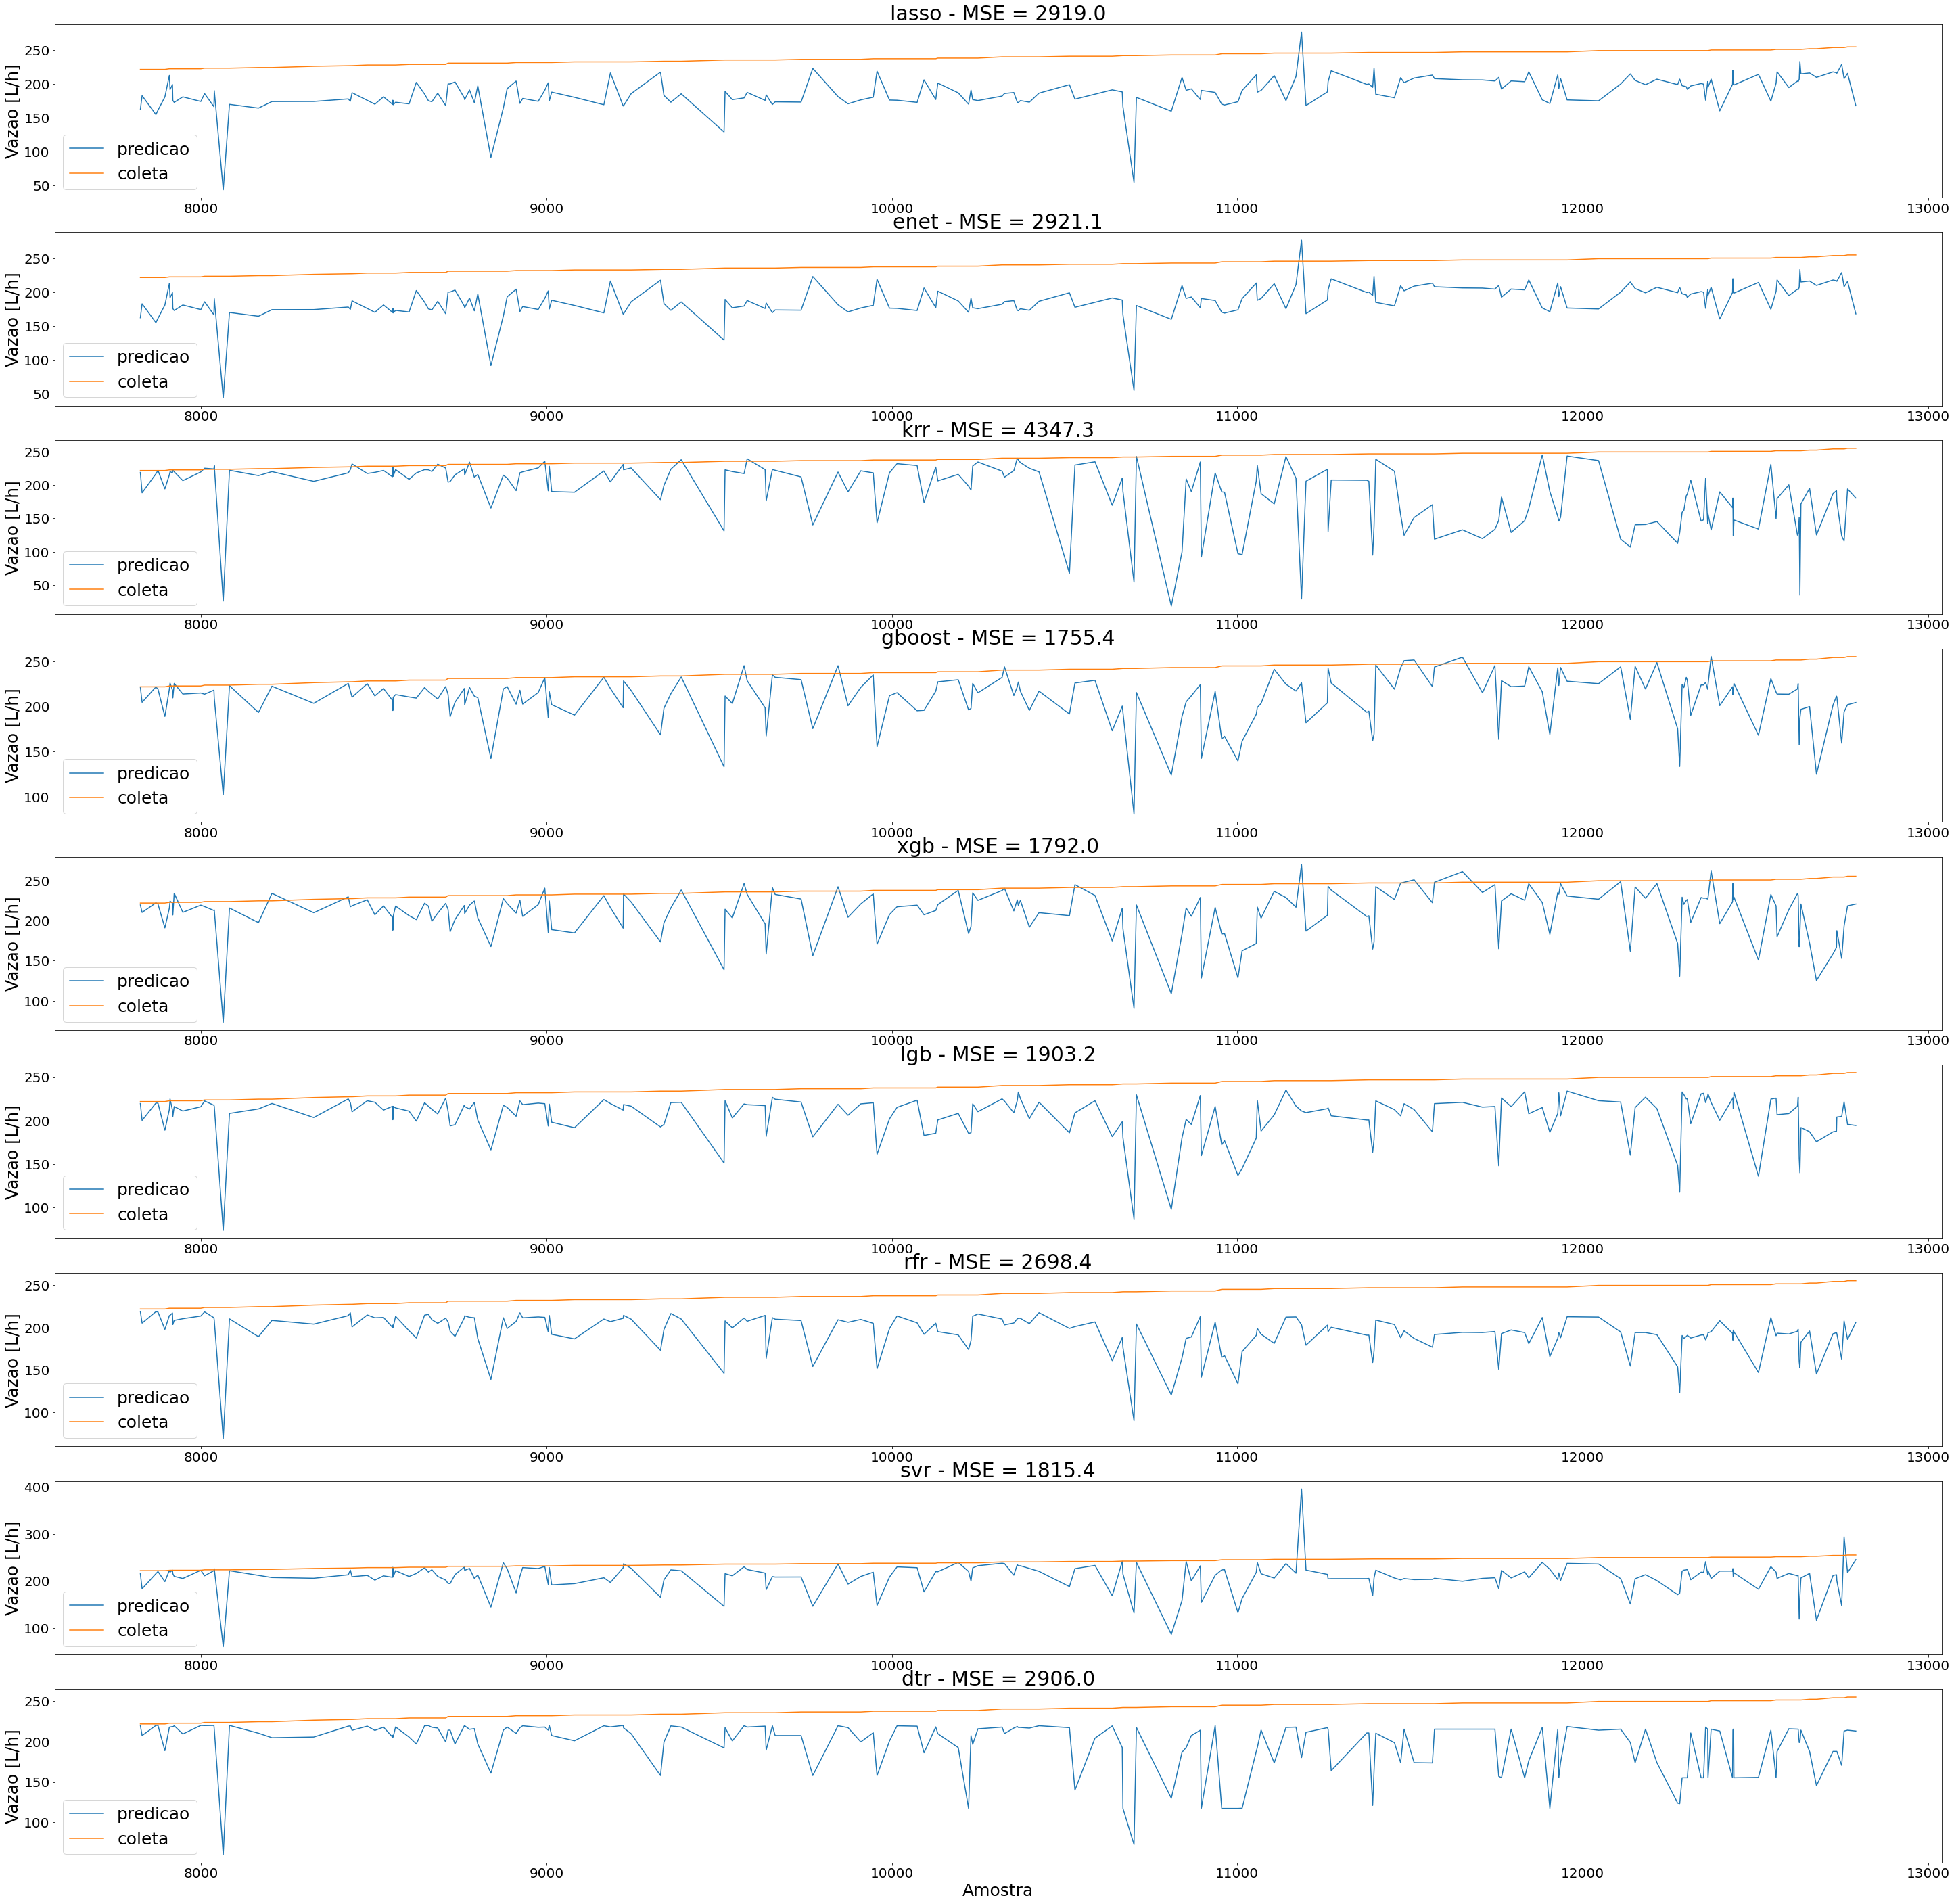

In [ ]:
#Plot de pontos de coleta e predicao

#Redução para visualizar parte aleatoria das amostras
df_predictions_plot = df_predictions.sample(n = 200).sort_index()

X_plot =    df_predictions_plot .index 
Y0_coleta = df_predictions_plot ['y_test']
Y1_lasso =  df_predictions_plot ['lasso']
Y2_enet =   df_predictions_plot ['enet']
Y3_krr =    df_predictions_plot ['krr']
Y4_gboost = df_predictions_plot ['gboost']
Y5_xgb =    df_predictions_plot ['xgb']
Y6_lgb =    df_predictions_plot ['lgb']
Y7_rfr =    df_predictions_plot ['rfr']
Y8_svr =    df_predictions_plot ['svr']
Y9_dtr =    df_predictions_plot ['dtr']

#Configuracoes de multiplas visualizacoes
figure, axis = plt.subplots(9,1, figsize=(50,50))

#  lasso
axis[0].plot(X_plot, Y1_lasso)
axis[0].plot(X_plot, Y0_coleta)
axis[0].set_title(f'lasso - MSE = {mse_list[0]:.1f}',fontsize=30)
axis[0].legend(['predicao', 'coleta'],loc=3,fontsize=25)
axis[0].set_ylabel('Vazao [L/h]',fontsize=25)
axis[0].tick_params(labelsize=20)

#  enet
axis[1].plot(X_plot, Y2_enet)
axis[1].plot(X_plot, Y0_coleta)
axis[1].set_title(f'enet - MSE = {mse_list[1]:.1f}',fontsize=30)
axis[1].legend(['predicao', 'coleta'],loc=3,fontsize=25)
axis[1].set_ylabel('Vazao [L/h]',fontsize=25)
axis[1].tick_params(labelsize=20)

#  krr
axis[2].plot(X_plot, Y3_krr)
axis[2].plot(X_plot, Y0_coleta)
axis[2].set_title(f'krr - MSE = {mse_list[2]:.1f}',fontsize=30)
axis[2].legend(['predicao', 'coleta'],loc=3,fontsize=25)
axis[2].set_ylabel('Vazao [L/h]',fontsize=25)
axis[2].tick_params(labelsize=20)

#  gboost
axis[3].plot(X_plot, Y4_gboost)
axis[3].plot(X_plot, Y0_coleta)
axis[3].set_title(f'gboost - MSE = {mse_list[3]:.1f}',fontsize=30)
axis[3].legend(['predicao', 'coleta'],loc=3,fontsize=25)
axis[3].set_ylabel('Vazao [L/h]',fontsize=25)
axis[3].tick_params(labelsize=20)

#  xgb
axis[4].plot(X_plot, Y5_xgb)
axis[4].plot(X_plot, Y0_coleta)
axis[4].set_title(f'xgb - MSE = {mse_list[4]:.1f}',fontsize=30)
axis[4].legend(['predicao', 'coleta'],loc=3,fontsize=25)
axis[4].set_ylabel('Vazao [L/h]',fontsize=25)
axis[4].tick_params(labelsize=20)

#  lgb
axis[5].plot(X_plot, Y6_lgb)
axis[5].plot(X_plot, Y0_coleta)
axis[5].set_title(f'lgb - MSE = {mse_list[5]:.1f}',fontsize=30)
axis[5].legend(['predicao', 'coleta'],loc=3,fontsize=25)
axis[5].set_ylabel('Vazao [L/h]',fontsize=25)
axis[5].tick_params(labelsize=20)

#  rfr
axis[6].plot(X_plot, Y7_rfr)
axis[6].plot(X_plot, Y0_coleta)
axis[6].set_title(f'rfr - MSE = {mse_list[6]:.1f}',fontsize=30)
axis[6].legend(['predicao', 'coleta'],loc=3,fontsize=25)
axis[6].set_ylabel('Vazao [L/h]',fontsize=25)
axis[6].tick_params(labelsize=20)

#  svr
axis[7].plot(X_plot, Y8_svr)
axis[7].plot(X_plot, Y0_coleta)
axis[7].set_title(f'svr - MSE = {mse_list[7]:.1f}',fontsize=30)
axis[7].legend(['predicao', 'coleta'],loc=3,fontsize=25)
axis[7].set_ylabel('Vazao [L/h]',fontsize=25)
axis[7].tick_params(labelsize=20)

#  dtr
axis[8].plot(X_plot, Y9_dtr)
axis[8].plot(X_plot, Y0_coleta)
axis[8].set_title(f'dtr - MSE = {mse_list[8]:.1f}',fontsize=30)
axis[8].legend(['predicao', 'coleta'],loc=3,fontsize=25)
axis[8].set_xlabel('Amostra',fontsize=25)
axis[8].set_ylabel('Vazao [L/h]',fontsize=25)
axis[8].tick_params(labelsize=20)


plt.show()



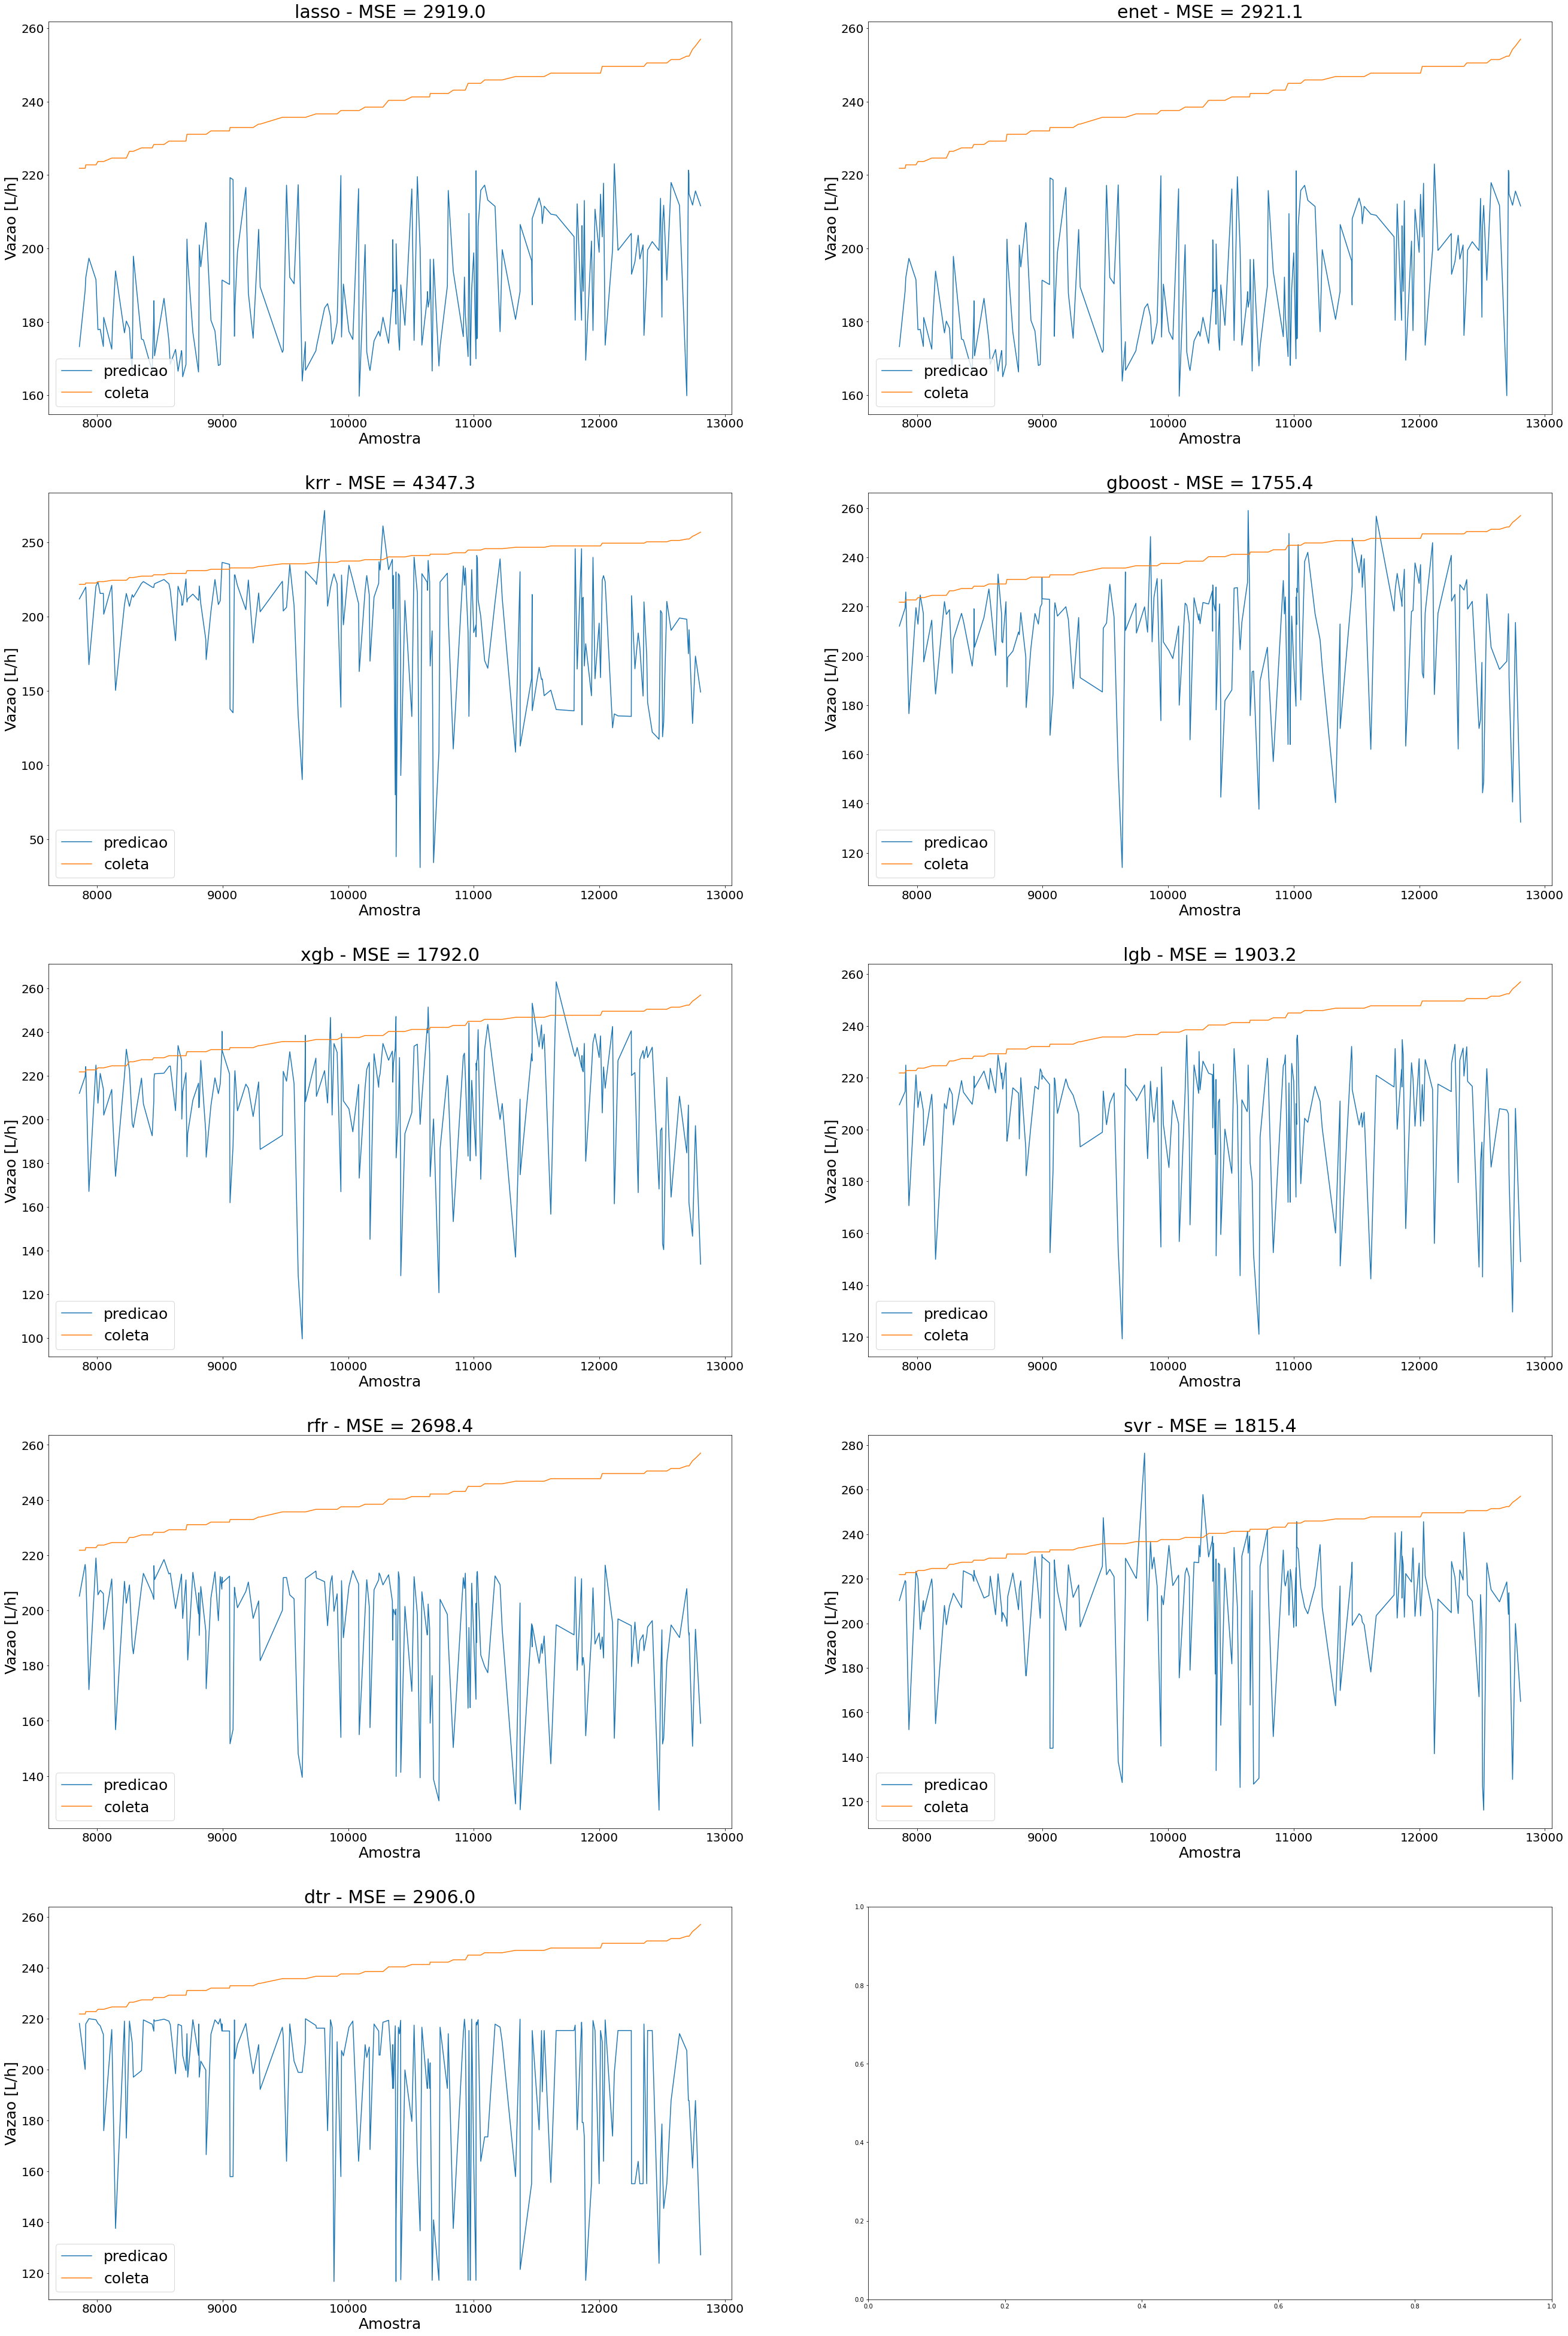

In [ ]:
#Plot de pontos de coleta e predicao

#Redução para visualizar parte aleatoria das amostras
df_predictions_plot = df_predictions.sample(n = 200).sort_index()

X_plot =    df_predictions_plot .index 
Y0_coleta = df_predictions_plot ['y_test']
Y1_lasso =  df_predictions_plot ['lasso']
Y2_enet =   df_predictions_plot ['enet']
Y3_krr =    df_predictions_plot ['krr']
Y4_gboost = df_predictions_plot ['gboost']
Y5_xgb =    df_predictions_plot ['xgb']
Y6_lgb =    df_predictions_plot ['lgb']
Y7_rfr =    df_predictions_plot ['rfr']
Y8_svr =    df_predictions_plot ['svr']
Y9_dtr =    df_predictions_plot ['dtr']

#Configuracoes de multiplas visualizacoes
figure, axis = plt.subplots(5, 2, figsize=(45,70))

#  lasso
axis[0, 0].plot(X_plot, Y1_lasso)
axis[0, 0].plot(X_plot, Y0_coleta)
axis[0, 0].set_title(f'lasso - MSE = {mse_list[0]:.1f}',fontsize=30)
axis[0, 0].legend(['predicao', 'coleta'],loc=3,fontsize=25)
axis[0, 0].set_xlabel('Amostra',fontsize=25)
axis[0, 0].set_ylabel('Vazao [L/h]',fontsize=25)
axis[0, 0].tick_params(labelsize=20)

#  enet
axis[0, 1].plot(X_plot, Y2_enet)
axis[0, 1].plot(X_plot, Y0_coleta)
axis[0, 1].set_title(f'enet - MSE = {mse_list[1]:.1f}',fontsize=30)
axis[0, 1].legend(['predicao', 'coleta'],loc=3,fontsize=25)
axis[0, 1].set_xlabel('Amostra',fontsize=25)
axis[0, 1].set_ylabel('Vazao [L/h]',fontsize=25)
axis[0, 1].tick_params(labelsize=20)

#  krr
axis[1,0].plot(X_plot, Y3_krr)
axis[1,0].plot(X_plot, Y0_coleta)
axis[1,0].set_title(f'krr - MSE = {mse_list[2]:.1f}',fontsize=30)
axis[1,0].legend(['predicao', 'coleta'],loc=3,fontsize=25)
axis[1,0].set_xlabel('Amostra',fontsize=25)
axis[1,0].set_ylabel('Vazao [L/h]',fontsize=25)
axis[1,0].tick_params(labelsize=20)

#  gboost
axis[1,1].plot(X_plot, Y4_gboost)
axis[1,1].plot(X_plot, Y0_coleta)
axis[1,1].set_title(f'gboost - MSE = {mse_list[3]:.1f}',fontsize=30)
axis[1,1].legend(['predicao', 'coleta'],loc=3,fontsize=25)
axis[1,1].set_xlabel('Amostra',fontsize=25)
axis[1,1].set_ylabel('Vazao [L/h]',fontsize=25)
axis[1,1].tick_params(labelsize=20)

#  xgb
axis[2,0].plot(X_plot, Y5_xgb)
axis[2,0].plot(X_plot, Y0_coleta)
axis[2,0].set_title(f'xgb - MSE = {mse_list[4]:.1f}',fontsize=30)
axis[2,0].legend(['predicao', 'coleta'],loc=3,fontsize=25)
axis[2,0].set_xlabel('Amostra',fontsize=25)
axis[2,0].set_ylabel('Vazao [L/h]',fontsize=25)
axis[2,0].tick_params(labelsize=20)

#  lgb
axis[2,1].plot(X_plot, Y6_lgb)
axis[2,1].plot(X_plot, Y0_coleta)
axis[2,1].set_title(f'lgb - MSE = {mse_list[5]:.1f}',fontsize=30)
axis[2,1].legend(['predicao', 'coleta'],loc=3,fontsize=25)
axis[2,1].set_xlabel('Amostra',fontsize=25)
axis[2,1].set_ylabel('Vazao [L/h]',fontsize=25)
axis[2,1].tick_params(labelsize=20)

#  rfr
axis[3,0].plot(X_plot, Y7_rfr)
axis[3,0].plot(X_plot, Y0_coleta)
axis[3,0].set_title(f'rfr - MSE = {mse_list[6]:.1f}',fontsize=30)
axis[3,0].legend(['predicao', 'coleta'],loc=3,fontsize=25)
axis[3,0].set_xlabel('Amostra',fontsize=25)
axis[3,0].set_ylabel('Vazao [L/h]',fontsize=25)
axis[3,0].tick_params(labelsize=20)

#  svr
axis[3,1].plot(X_plot, Y8_svr)
axis[3,1].plot(X_plot, Y0_coleta)
axis[3,1].set_title(f'svr - MSE = {mse_list[7]:.1f}',fontsize=30)
axis[3,1].legend(['predicao', 'coleta'],loc=3,fontsize=25)
axis[3,1].set_xlabel('Amostra',fontsize=25)
axis[3,1].set_ylabel('Vazao [L/h]',fontsize=25)
axis[3,1].tick_params(labelsize=20)

#  dtr
axis[4,0].plot(X_plot, Y9_dtr)
axis[4,0].plot(X_plot, Y0_coleta)
axis[4,0].set_title(f'dtr - MSE = {mse_list[8]:.1f}',fontsize=30)
axis[4,0].legend(['predicao', 'coleta'],loc=3,fontsize=25)
axis[4,0].set_xlabel('Amostra',fontsize=25)
axis[4,0].set_ylabel('Vazao [L/h]',fontsize=25)
axis[4,0].tick_params(labelsize=20)


plt.show()